<a href="https://colab.research.google.com/github/codelspak/Struggles/blob/main/WK27_case1_Kaggle_ML_Regression_NewYork_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NewYork Taxi Fare Prediction 필사 프로젝트 #3 뉴욕 시내 탑승/하차지에 따른 택시 요금(톨게이트 비 포함) 예측
[Kaggle 노트북 출처](https://www.kaggle.com/code/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters)

    1) ID - 각 샘플이 갖는 고유 Key (pickup_datetime + a unique integer)
        * Cross-validation에서 submission file 시뮬레이션 할 때 쓰이므로, 삭제X
    2) Features 
        - pickup_datetime -  승차시간
        - pickup_longitude - 승차지 위도
        - pickup_latitude - 승차지 경도
        - dropoff_longitude - 하차지 위도
        - dropoff_latitude - 하차지 경도
        - passenger_count - 택시 승객 수
    3) Target
        - fare_amount - 택시 요금($USD)


# 1. 필요한 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np # 선형대수
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

import os

In [2]:
# chunksize = 10**3
# for cnt, chunk in enumerate(pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/new-york-city-taxi-fare-prediction/train.csv', chunksize = chunksize)) :
#     do_something(chunk)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train1 = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/train1.csv')
train2 = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/train2.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
train = pd.concat([train1, train2])
test = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/new-york-city-taxi-fare-prediction/test.csv')

# 2. Data Cleansing / EDA
    - train/test dataset shape 확인
    - 결측치 확인 후 drop (if any)
    - 이상치 확인 후 drop (if any)
    - Type conversion of relevant fields

### 2.1. train/test dataset shape 확인

In [6]:
train.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
483473    False
483474    False
483475    False
483476    False
483477    False
Length: 1532053, dtype: bool

In [7]:
train = train.drop_duplicates()

In [8]:
print(train.shape)
train.head()

(1048576, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [9]:
pd.options.display.float_format = '{:.5f}'.format
# 다시 과학적 표기법으로 나타내고 싶을 땐 :   pd.reset_option('display.float_format')
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1048575.00000,1048575.00000,1048575.00000,1048565.00000,1048565.00000,1048575.00000
mean,11.34548,-72.52724,39.93094,-72.52750,39.92496,1.68490
std,9.82007,12.00798,7.72581,11.41154,8.52959,1.32315
min,-44.90000,-3377.68093,-3116.28538,-3383.29661,-3114.33857,0.00000
25%,6.00000,-73.99207,40.73496,-73.99138,40.73406,1.00000
50%,8.50000,-73.98180,40.75267,-73.98014,40.75318,1.00000
75%,12.50000,-73.96711,40.76714,-73.96367,40.76812,2.00000
max,500.00000,2522.27133,2621.62843,1717.00340,1989.72808,208.00000


위의 기술통계 값을 보았을 때, 탐색적 데이터 분석 및 전처리가 필요한 포인트를 도출 가능함<br>
1. fare_amount : 택시요금은 음수가 존재할 수 없음 / 3사분위 이후 값 편차가 너무 큼
2. pickup_longtitude / pickup_latitude / dropoff_longtitude / dropoff_latitude : <br> 얘 역시 뉴욕시 위도/경도의 범위에서 벗어난 값이 있으면 처리해줘야 함 <br>
    - Latitudes : (-90, 90)
    - Longitudes : (-180, 180)
3. passenger_count : 버스 등을 감안해도 최대 탑승 가능 승객 수는 50여 명 예상<br> max값 208명에 주의해서 분포 확인


### 2.2 데이터 cleansing

#### 결측치 확인 후 drop (if any)

In [10]:
# train 
train.isnull().sum().sort_values(ascending = False)

dropoff_longitude    11
dropoff_latitude     11
key                   1
fare_amount           1
pickup_datetime       1
pickup_longitude      1
pickup_latitude       1
passenger_count       1
dtype: int64

In [11]:
# train - null - drop
train = train.drop(train[train.isnull().any(1)].index, axis = 0)
train.shape

(1048556, 8)

#### 이상치 확인 후 drop (if any)
이상치는 데이터가 분포한 주요 구간 외에 위치한 것 외에 feature 정의 상 존재할 수 없는 값도 포함됨 <br>


##### fare_amount

In [12]:
train['fare_amount'].describe()

count   1048556.00000
mean         11.34540
std           9.81982
min         -44.90000
25%           6.00000
50%           8.50000
75%          12.50000
max         500.00000
Name: fare_amount, dtype: float64

fare_amount의 경우, (1) 음의 값과 (2) 3사분위 수 대비 과도하게 큰 값(500)을 확인 후 처리해주겠음<br>
(참고) 아래 함수를 이용해서, 조건에 해당하는 데이터 수를 쉽게 카운트할 수 있음<br>
[collections.Counter 함수 사용법](https://www.daleseo.com/python-collections-counter/)

In [13]:
from collections import Counter

# 택시 요금이 음의 값인 데이터 수 확인
Counter(train['fare_amount']<0)

Counter({False: 1048516, True: 40})

In [14]:
# 음의 값을 갖는 요금 데이터 제거 
train = train.drop(train[train['fare_amount']<0].index, axis = 0)
train.shape

(1048480, 8)

In [15]:
train['fare_amount'].describe()

count   1048480.00000
mean         11.34602
std           9.81929
min           0.00000
25%           6.00000
50%           8.50000
75%          12.50000
max         500.00000
Name: fare_amount, dtype: float64

In [16]:
# 과도하게 큰 값을 갖는 데이터 확인
train['fare_amount'].sort_values(ascending = False).head(10)

101885   500.00000
247671   495.00000
329010   450.00000
233874   450.00000
287638   450.00000
361793   400.00000
451974   400.00000
386713   347.54000
439178   325.00000
13822    287.08000
Name: fare_amount, dtype: float64

##### pickup/droppoff longtitude/latitude
(기준) 뉴욕 시 위도 경도 범위<br>
    - Latitudes (-90, 90)<br>
    - Longtitudes (-180,180)


In [17]:
train['pickup_latitude'].describe()

count   1048480.00000
mean         39.93094
std           7.72596
min       -3116.28538
25%          40.73496
50%          40.75267
75%          40.76714
max        2621.62843
Name: pickup_latitude, dtype: float64

In [18]:
# 데이터 정의에서 벗어나는 -90 미만, 90 초과 데이터 확인
display(train[train['pickup_latitude']<-90])
print('-'*160)
display(train[train['pickup_latitude']>90])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
150559,43:00.0,25.30000,2012-08-03 07:43:00 UTC,0.00000,-3116.28538,-73.95360,40.78800,1.00000
436233,56:00.0,4.10000,2012-03-11 01:56:00 UTC,-2986.24249,-880.62743,-3383.29661,-2559.74891,1.00000
543001,53:00.0,5.30000,2011-10-28 13:53:00 UTC,-3377.68093,-113.01950,-554.91869,314.79418,1.00000


----------------------------------------------------------------------------------------------------------------------------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
5686,15:00.0,3.30000,2011-07-30 11:15:00 UTC,-73.94724,401.08333,-73.95139,40.77893,1.00000
174356,36:00.0,9.70000,2011-11-21 21:36:00 UTC,2140.60116,1703.09277,-1251.19589,-1189.61544,1.00000
272439,55:00.0,9.30000,2011-04-23 02:55:00 UTC,-74.00250,405.35000,-73.97860,40.73996,1.00000
464025,58:00.0,6.90000,2012-03-05 20:58:00 UTC,-73.99427,404.96667,-73.97386,40.75546,1.00000
505229,08:00.0,9.30000,2012-03-05 21:08:00 UTC,-73.99427,404.96667,-73.98639,40.77690,1.00000
505583,13:00.0,8.50000,2012-03-16 08:13:00 UTC,-73.99428,405.13333,-73.95676,40.78374,1.00000
123588,40:00.0,17.30000,2012-03-22 21:40:00 UTC,2522.27133,2621.62843,-1718.11765,-2864.47100,1.00000
142962,44:00.0,5.30000,2012-05-24 22:44:00 UTC,-73.98919,91.26667,-73.98236,40.76311,1.00000
405171,31:00.0,5.70000,2012-04-12 07:31:00 UTC,-73.95709,424.08333,-73.96831,40.76512,1.00000
454771,34:00.0,7.70000,2011-05-19 00:34:00 UTC,351.05252,1669.58204,1717.00340,1989.72808,1.00000


In [19]:
# 위 범위 밖 데이터drop
train = train.drop( train[(train['pickup_latitude']<-90) | (train['pickup_latitude']>90)].index, axis = 0 )
train.shape

(1048457, 8)

In [20]:
train['pickup_latitude'].describe()

count   1048457.00000
mean         39.92725
std           6.08715
min         -74.01659
25%          40.73496
50%          40.75267
75%          40.76714
max          69.40000
Name: pickup_latitude, dtype: float64

In [21]:
train['pickup_longitude'].describe()

count   1048457.00000
mean        -72.52642
std          10.69610
min       -1452.98833
25%         -73.99207
50%         -73.98180
75%         -73.96711
max          40.85036
Name: pickup_longitude, dtype: float64

In [22]:
# 데이터 정의에서 벗어나는 -180 미만, 180 초과 데이터 확인
display(train[train['pickup_longitude']<-180])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
60442,36:00.0,4.90000,2012-01-12 13:36:00 UTC,-736.55000,40.73823,-73.98874,40.74885,1.00000
217355,21:00.0,6.10000,2012-06-03 23:21:00 UTC,-740.00000,40.74762,0.00000,0.00000,6.00000
243342,38:00.0,7.30000,2012-08-02 10:38:00 UTC,-736.33333,40.76648,-73.98793,40.75174,3.00000
351119,53:00.0,4.10000,2012-02-03 07:53:00 UTC,-736.48333,40.76651,-73.98199,40.77167,1.00000
370663,19:00.0,6.10000,2012-05-04 23:19:00 UTC,-736.51667,40.71910,-74.00395,40.72986,1.00000
416859,23:00.0,6.50000,2012-07-21 15:23:00 UTC,-736.41666,40.75229,-73.99256,40.74269,1.00000
3733,23:00.0,11.50000,2013-05-23 15:23:00 UTC,-735.88833,40.76086,-73.98983,40.73844,5.00000
110403,53:00.0,16.90000,2011-10-28 10:53:00 UTC,-1452.98833,40.77600,-73.98949,40.74067,2.00000
272522,38:00.0,39.70000,2012-07-17 08:38:00 UTC,-736.00000,40.75851,0.00000,0.00000,5.00000
349338,10:00.0,11.70000,2012-03-04 00:10:00 UTC,-736.25000,40.78803,-73.99081,40.75094,1.00000


In [23]:
# 위 범위 밖 데이터drop
train = train.drop( train[train['pickup_longitude']<-180].index, axis = 0 )
train.shape

(1048433, 8)

In [24]:
train['pickup_longitude'].describe()

count   1048433.00000
mean        -72.51812
std          10.39055
min        -128.17595
25%         -73.99207
50%         -73.98180
75%         -73.96711
max          40.85036
Name: pickup_longitude, dtype: float64

In [25]:
train['dropoff_latitude'].describe()

count   1048433.00000
mean         39.92947
std           7.28826
min       -3114.33857
25%          40.73406
50%          40.75318
75%          40.76812
max        1903.11157
Name: dropoff_latitude, dtype: float64

In [26]:
# 데이터 정의에서 벗어나는 -90 미만, 90 초과 데이터 확인
display(train[train['dropoff_latitude']<-90])
print('-'*160)
display(train[train['dropoff_latitude']>90])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
14804,23:00.0,18.00000,2013-08-14 20:23:00 UTC,-73.99919,40.72020,-0.36000,-3114.33857,1.00000


----------------------------------------------------------------------------------------------------------------------------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
92310,54:00.0,28.90000,2011-09-27 11:54:00 UTC,-74.01459,40.68188,-73.97331,404.61667,1.00000
181973,04:00.0,6.50000,2012-01-03 09:04:00 UTC,-74.00892,40.71783,-74.00086,404.13333,1.00000
335675,25:00.0,19.30000,2012-02-26 00:25:00 UTC,-74.00646,40.74386,-73.98128,404.13333,1.00000
561910,42:59.0,4.50000,2010-08-14 03:42:59 UTC,-73.97764,40.75469,-73.87043,405.65000,1.00000
17013,20:00.0,30.50000,2012-05-02 14:20:00 UTC,-73.87087,40.77379,-73.97779,404.71667,1.00000
183367,33:00.0,15.00000,2013-01-02 11:33:00 UTC,-74.01520,40.70967,-40.71930,1651.55343,5.00000
324607,15:00.0,15.30000,2012-05-21 12:15:00 UTC,-74.00129,40.72756,-73.95305,404.46667,1.00000
476418,36:00.0,14.90000,2012-06-11 14:36:00 UTC,-73.94987,40.82220,0.00000,1903.11157,1.00000


In [27]:
# 위 범위 밖 데이터drop
train = train.drop( train[(train['dropoff_latitude']<-90) | (train['dropoff_latitude']>90)].index, axis = 0 )
train.shape

(1048416, 8)

In [28]:
train['dropoff_latitude'].describe()

count   1048416.00000
mean         39.92707
std           6.08933
min         -74.03520
25%          40.73406
50%          40.75318
75%          40.76812
max          81.51018
Name: dropoff_latitude, dtype: float64

In [29]:
train['dropoff_longitude'].describe()

count   1048416.00000
mean        -72.52343
std          10.60900
min       -1329.62133
25%         -73.99138
50%         -73.98014
75%         -73.96367
max          45.58162
Name: dropoff_longitude, dtype: float64

In [30]:
# 데이터 정의에서 벗어나는 -180 미만, 180 초과 데이터 확인
display(train[train['dropoff_longitude']<-180])
print('-'*160)
display(train[train['dropoff_longitude']>180])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
269695,00:00.0,17.70000,2012-05-24 09:00:00 UTC,-73.99757,40.72095,-1329.62133,40.77372,1.00000
282374,09:00.0,5.70000,2011-04-25 13:09:00 UTC,-73.98710,40.75573,-732.60000,40.74483,1.00000
449263,51:00.0,6.90000,2012-01-28 16:51:00 UTC,-73.98314,40.74199,-736.50000,40.75525,1.00000
472273,42:00.0,49.80000,2012-02-09 17:42:00 UTC,-73.93717,40.75811,-736.08333,40.75811,6.00000
101255,02:00.0,4.90000,2012-03-16 22:02:00 UTC,-73.99260,40.72682,-472.26667,40.73333,1.00000
191906,45:00.0,3.30000,2012-04-29 20:45:00 UTC,-73.99067,40.76104,-736.55000,40.76018,5.00000
293663,41:00.0,6.10000,2012-06-19 07:41:00 UTC,-73.98247,40.77161,-736.41666,40.76431,1.00000
342695,22:00.0,8.10000,2012-02-18 00:22:00 UTC,-73.99121,40.75073,-740.00000,40.72662,1.00000
402065,42:00.0,5.70000,2012-02-09 17:42:00 UTC,-74.00639,40.73955,-740.06667,40.72479,1.00000


----------------------------------------------------------------------------------------------------------------------------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


In [31]:
# 위 범위 밖 데이터drop
train = train.drop( train[(train['dropoff_longitude']<-180) | (train['dropoff_longitude']>180)].index, axis = 0 )
train.shape

(1048398, 8)

In [32]:
train['dropoff_longitude'].describe()

count   1048398.00000
mean        -72.51747
std          10.38946
min        -121.39125
25%         -73.99138
50%         -73.98014
75%         -73.96367
max          45.58162
Name: dropoff_longitude, dtype: float64

##### passenger_count

In [33]:
train['passenger_count'].describe()

count   1048398.00000
mean          1.68492
std           1.32315
min           0.00000
25%           1.00000
50%           1.00000
75%           2.00000
max         208.00000
Name: passenger_count, dtype: float64

3사분위와 max 값 사이 편차가 너무 크고, '택시'는 일반적으로 많아봤자 10인승 전후임. 208명의 승객에 대한 확인이 필요함<br>
SUV를 탄다 가정했을 떄 그나마 주변에서 볼 수 있는 9인승 대형 택시를 기준으로, 그 이상의 승객을 태운 데이터가 얼마나 되는지 확인해보겠음

In [34]:
train[train['passenger_count']>9]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
363925,54:00.0,3.30000,2009-07-30 11:54:00 UTC,0.00000,0.00000,0.00000,0.00000,208.00000


In [35]:
train = train.drop(train[train['passenger_count']==208].index, axis = 0)
train.shape

(1048396, 8)

In [36]:
train['passenger_count'].describe()

count   1048396.00000
mean          1.68472
std           1.30772
min           0.00000
25%           1.00000
50%           1.00000
75%           2.00000
max           9.00000
Name: passenger_count, dtype: float64

### 2.3. 탐색적 데이터 분석(EDA)

#### 데이터 유형 확인 및 변경

In [37]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

key, pickup_datetime은 datetime의 값을 가지고 있지만, object type에 저장되어 있음. 얘네 datetime으로 바꿔줌

In [39]:
# train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [46]:
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [47]:
train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [48]:
test.dtypes

key                       datetime64[ns]
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [49]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.50000,2009-06-15 17:26:21+00:00,-73.84431,40.72132,-73.84161,40.71228,1.00000
1,52:16.0,16.90000,2010-01-05 16:52:16+00:00,-74.01605,40.71130,-73.97927,40.78200,1.00000
2,35:00.0,5.70000,2011-08-18 00:35:00+00:00,-73.98274,40.76127,-73.99124,40.75056,2.00000
3,30:42.0,7.70000,2012-04-21 04:30:42+00:00,-73.98713,40.73314,-73.99157,40.75809,1.00000
4,51:00.0,5.30000,2010-03-09 07:51:00+00:00,-73.96810,40.76801,-73.95665,40.78376,1.00000


In [50]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24+00:00,-73.97332,40.76381,-73.98143,40.74384,1
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24+00:00,-73.98686,40.71938,-73.99889,40.73920,1
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44+00:00,-73.98252,40.75126,-73.97965,40.74614,1
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12+00:00,-73.98116,40.76781,-73.99045,40.75164,1
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12+00:00,-73.96605,40.78977,-73.98856,40.74443,1


##### 탐색적 데이터 분석 with 4 questions
    1. 승객 수 - 요금 사이 관계 여부
    2. 승차 일/시간 - 요금 사이 관계 여부
    3. 요일 - 요금 사이 관계 여부
    4. 주행거리 - 요금 사이 관계 여부

###### 1. 승객 수 - 요금 사이 관계 여부
승객 수에 따른 택시 승하차 빈도 수와 요금 분포를, 히스토그램과 산점도를 통해 시각화 함.<br>
아래 두 그래프를 통해 택시 승하차가 가장 빈번한 승객 수는 1명이며, 요금이 가장 높았을 때 역시 승객 수가 1명이었음을 알 수 있음.

Text(0, 0.5, 'Frequency')

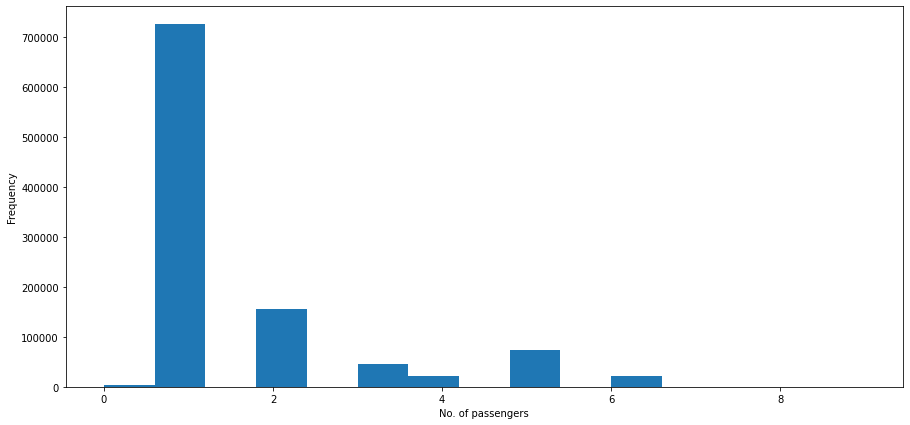

In [58]:
plt.figure(figsize = (15,7))
plt.hist(train['passenger_count'], bins = 15)
plt.xlabel('No. of passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

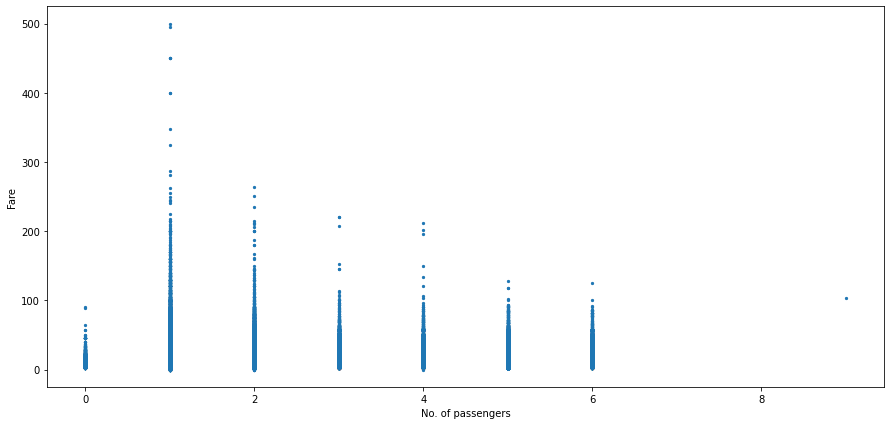

In [65]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['passenger_count'], y = train['fare_amount'], s = 5)
plt.xlabel('No. of passengers')
plt.ylabel('Fare')

######  2. 승차 일/시간 - 요금 사이 관계 여부

In [51]:
# pickup_datetime > year, month, date, hour, day of week 파생변수 생성

# train, test 모두 적용해주기 위해, data라는 list로 묶어서 한 번에 수정해줌
data = [train, test]

for df in data :
    df['year'] = df['pickup_datetime'].dt.year 
    df['month'] = df['pickup_datetime'].dt.month 
    df['date'] = df['pickup_datetime'].dt.day 
    df['hour'] = df['pickup_datetime'].dt.hour 
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek 


In [52]:
display(train.head(3))
display(test.head(3))

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek
0,26:21.0,4.50000,2009-06-15 17:26:21+00:00,-73.84431,40.72132,-73.84161,40.71228,1.00000,2009,6,15,17,0
1,52:16.0,16.90000,2010-01-05 16:52:16+00:00,-74.01605,40.71130,-73.97927,40.78200,1.00000,2010,1,5,16,1
2,35:00.0,5.70000,2011-08-18 00:35:00+00:00,-73.98274,40.76127,-73.99124,40.75056,2.00000,2011,8,18,0,3


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24+00:00,-73.97332,40.76381,-73.98143,40.74384,1,2015,1,27,13,1
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24+00:00,-73.98686,40.71938,-73.99889,40.73920,1,2015,1,27,13,1
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44+00:00,-73.98252,40.75126,-73.97965,40.74614,1,2011,10,8,11,5


아래 시각화를 통해 다음과 같은 사실을 확인할 수 있음<br>
1. Month/Date : 택시 승하차 빈도 및 요금은 대체로 균일함. 
2. Hour : 새벽5시에 승하차 빈도가 가장 낮음 / 오후 8시 가량에 가장 승하차 많이 발생<br>
큰 차이는 아니지만 요금 역시, 시간에 따라 높고 낮음의 차이가 발생<br>
    -> important feature로 작용 예상


Text(0, 0.5, 'Fare')

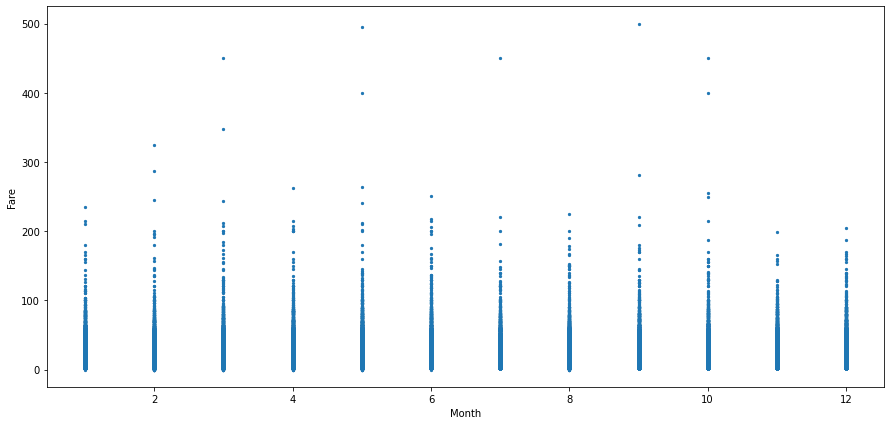

In [70]:
# 시각화
plt.figure(figsize=(15,7))
plt.scatter(x=train['month'], y=train['fare_amount'], s=5)
plt.xlabel('Month')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

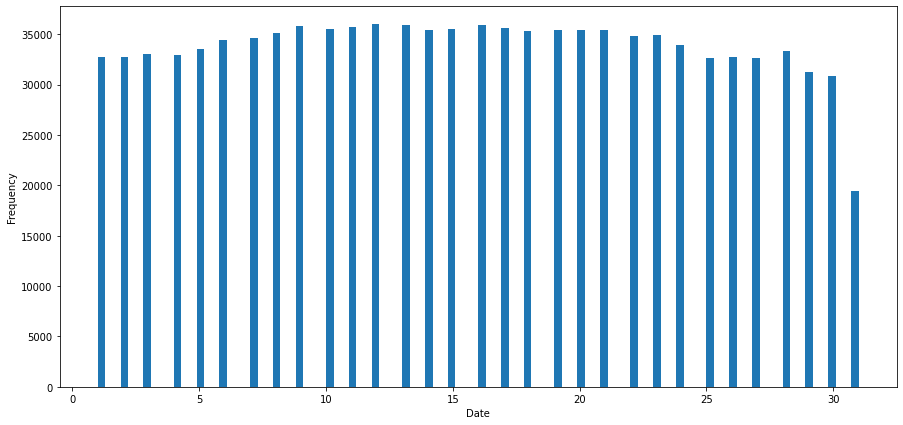

In [71]:
plt.figure(figsize=(15,7))
plt.hist(train['date'], bins=100)
plt.xlabel('Date')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

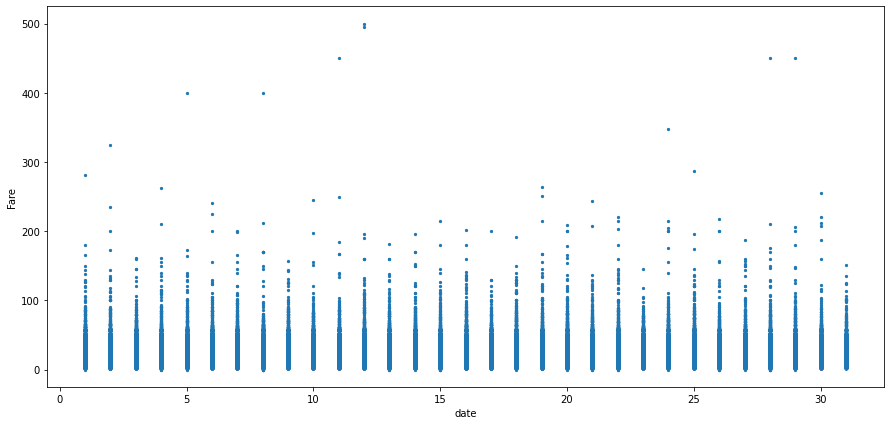

In [68]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['date'], y=train['fare_amount'], s=5)
plt.xlabel('date')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

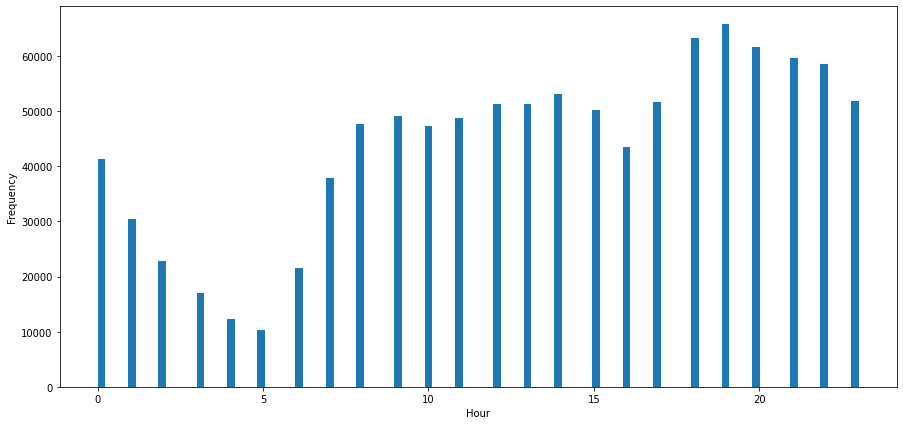

In [72]:
plt.figure(figsize=(15,7))
plt.hist(train['hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

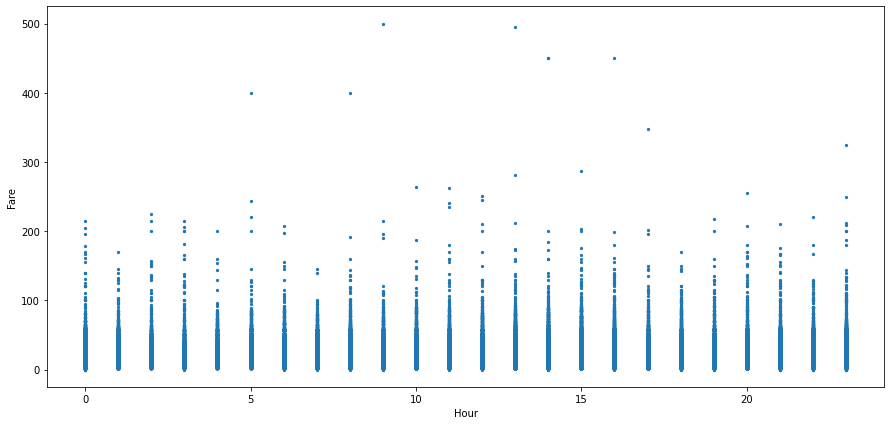

In [73]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['hour'], y=train['fare_amount'], s=5)
plt.xlabel('Hour')
plt.ylabel('Fare')

###### 3. 요일 - 요금 사이 관계 여부

###### 4. 주행거리 - 요금 사이 관계 여부
주행거리는 Haversine formula에 의거해서 구해줌<br>
Harversine formula : 지구를 구(sphere)로 가정, 두 지점의 좌표(경도, 위도)를 이용하여 지구 표면 상의 대원 거리(great-circle distance)를 계산<br>

```
haversine(θ) = sin²(θ/2)
φ = latitude / λ = longitude, R = earth’s radius (mean radius = 6,371km) 
A, B : pickup / dropoff location 좌표
    1. a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    2. c = 2 * atan2( √a, √(1−a) )
    3. d = R ⋅ c
    4. d = Haversine distance
```

In [53]:
# 위 공식에 의해(1~4), 승차지 - 하차지 사이 Harversine distance 구하는 함수 정의해줌
def harversine_distance(lat1, long1, lat2, long2): # 아래에서 정의한 내용에 따라, lat1/long1/lat2/long2는 train, test 데이터의 column 명이라는 걸 알 수 있다!
    data = [train, test]
    for df in data :
        R = 6371 # 지구 반지름 (단위 : km)
        phi1 = np.radians(df[lat1]) # π rad = 180도
        phi2 = np.radians(df[lat2])

        delta_phi = np.radians(df[lat2]-df[lat1])
        delta_lambda = np.radians(df[long2]-df[long1])

        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin( delta_phi/2 )**2 + np.cos(phi1) * np.cos(phi2) * (np.sin(delta_lambda/2) ** 2)
        # c
        c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) )
        # d
        d = R * c # 단위 : km
        df['haver_distance'] = d
    return d

In [55]:
# pickup - dropoff location 사이 거리 구하기 위해, distance 컬럼 만들어줌
harversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0       2.32326
1       2.42535
2       0.61863
3       1.96103
4       5.38730
         ...   
9909    2.12487
9910    3.27097
9911   19.18394
9912    8.34349
9913    1.18083
Length: 9914, dtype: float64

In [56]:
train['haver_distance'].head(10)

0   1.03076
1   8.45013
2   1.38953
3   2.79927
4   1.99916
5   3.78724
6   1.55581
7   4.15544
8   1.25323
9   2.84963
Name: haver_distance, dtype: float64

In [57]:
test.haver_distance.head(10)

0    2.32326
1    2.42535
2    0.61863
3    1.96103
4    5.38730
5    3.22255
6    0.92960
7   21.54010
8    3.87396
9    1.09979
Name: haver_distance, dtype: float64

결론

향후 추가로 해 볼 필사작업
[Kaggle 뉴욕 택시 가격 예측 - 노트북2](https://www.kaggle.com/code/breemen/nyc-taxi-fare-data-exploration)